In [93]:
!pip install pip==23.2.1 setuptools==65.5.1

In [94]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [95]:
# connect S3 bucket
bucket = "mscproject10"
datakey = "high_dimensional_data10000.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject10/high_dimensional_data10000.csv


In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [97]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_9991,feature_9992,feature_9993,feature_9994,feature_9995,feature_9996,feature_9997,feature_9998,feature_9999,target
0,2.454098,0.816774,0.132215,0.024976,0.682239,1.258744,-1.305518,-0.189741,0.835101,-0.140940,...,-0.434965,0.547228,0.223023,0.161017,0.775480,0.098316,-1.240837,-0.805878,-0.087913,0
1,0.860796,-0.244772,-0.351094,-1.640961,-1.947639,2.076183,0.269064,-0.670954,0.307772,-0.003178,...,-0.680371,1.528356,1.443530,0.811401,-1.628922,0.819983,-0.231795,0.373770,-1.425353,0
2,-0.150684,-0.319311,-0.207553,2.802130,0.074340,1.268716,1.083233,1.589742,0.194696,0.951059,...,0.193950,0.162886,-0.278911,-0.524252,0.850884,-0.498867,-0.074053,-0.669552,1.785995,1
3,1.649634,-1.057194,0.654085,-0.948730,0.878978,1.690100,0.923063,0.902591,0.677751,0.525010,...,-0.832195,0.224670,1.661484,-0.160928,-0.563453,0.103668,-1.300604,0.970631,0.708955,1
4,0.221880,0.804163,0.948763,0.682788,1.241332,0.295260,-0.074335,2.783645,0.161296,-0.799285,...,1.374845,-0.018603,0.126844,-0.032235,-1.135801,-0.527198,0.311151,0.231474,0.093938,0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 10001 entries, feature_0 to target
dtypes: float64(10000), int64(1)
memory usage: 763.0 MB


In [99]:
# Reduce memory

from numpy import float64, float32, int64, int32, dtype

map_dtypes = {
    'int': dtype(int64),
    'float': dtype(float32)
    }

for col in df:
    if df[col].dtype == dtype(int64):
        df[col] = df[col].astype(int32)
    if df[col].dtype == dtype(float64):
        df[col] = df[col].astype(float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 10001 entries, feature_0 to target
dtypes: float32(10000), int32(1)
memory usage: 381.5 MB


In [100]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_9991,feature_9992,feature_9993,feature_9994,feature_9995,feature_9996,feature_9997,feature_9998,feature_9999,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.003664,0.006519,0.002011,0.000721,0.000161,0.001396,0.006700,0.012500,0.002882,-0.008416,...,0.011681,0.001170,0.012078,-0.003763,0.010206,-0.000783,0.001082,-0.001764,-0.008275,0.499700
std,0.989647,0.997248,1.006663,0.998329,0.990660,0.992080,1.007237,0.987799,0.998435,0.999215,...,1.002501,1.003169,0.993285,0.995493,0.999614,1.007320,0.997921,0.999667,0.995914,0.500025
min,-3.789513,-4.321838,-3.505685,-3.455650,-3.673690,-3.528998,-3.678004,-4.344101,-3.687669,-3.774779,...,-3.897374,-4.451093,-3.394060,-3.828846,-4.048288,-3.854213,-3.886283,-3.932869,-4.862923,0.000000
25%,-0.670193,-0.665659,-0.668871,-0.673690,-0.671726,-0.669386,-0.658607,-0.646175,-0.676525,-0.680647,...,-0.654584,-0.677764,-0.659092,-0.675794,-0.666855,-0.693445,-0.662706,-0.680669,-0.667565,0.000000
50%,-0.023311,0.003518,0.021733,-0.002892,0.004022,-0.002240,0.018146,0.017635,-0.003342,-0.001929,...,0.008786,-0.005367,0.013764,0.005510,0.002509,0.000415,0.007457,0.005413,-0.012186,0.000000
75%,0.662979,0.683524,0.683009,0.664872,0.671877,0.679590,0.680681,0.667497,0.688284,0.658459,...,0.687476,0.686889,0.686474,0.675861,0.701451,0.688265,0.654694,0.680972,0.650719,1.000000
max,3.730539,4.102155,3.734860,3.646937,3.892716,3.698061,3.679615,3.732501,4.146582,3.452134,...,4.236712,3.768659,3.528127,4.099897,3.591830,3.771472,3.638550,4.489021,4.376378,1.000000


In [101]:
df.shape

(10000, 10001)

In [102]:
print(df.isnull().sum()[df.isnull().sum() > 0])
df.duplicated().sum()


Series([], dtype: int64)


0

In [103]:
# Drop non-numeric columns if any and separate features & target
X = df.drop(columns=['target'])  # Adjust according to dataset
y = df['target']

In [104]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 10000), (2000, 10000), (8000,), (2000,))

In [105]:
models = {
    "XGBoost": {
        "model": XGBRegressor(tree_method="hist", random_state=42),  # Remove device="cuda"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),  # Remove device_type="gpu"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6]
        }
    },
    "HistGradientBoosting": {
        "model": HistGradientBoostingRegressor(random_state=42),
        "params": {
            "max_iter": [100, 200],  # Note: parameter name is max_iter, not n_estimators
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),  # Remove task_type="GPU"
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    }
}

In [ ]:
# Train & evaluate models
results = {}
for name, config in models.items():
    print(f"\n=== Tuning {name} ===")
    
    # GridSearchCV for best hyperparameters
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    start_time = time.time()
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Predict & evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "MSE": mse,
        "Time (s)": round(time.time() - start_time, 2)
    }
    
    print(f"Best Params: {grid.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"Training Time: {results[name]['Time (s)']}s")

# Display final results
print("\n=== Model Performance Summary ===")
results_df = pd.DataFrame(results).T
# Sort the models by MSE and display the performance
print(results_df[['MSE', 'Time (s)']].sort_values('MSE'))


=== Tuning XGBoost ===


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
MSE: 0.0963
Training Time: 920.45s

=== Tuning LightGBM ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.007892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550000
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 10000
[LightGBM] [Info] Start training from score 0.507782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
MSE: 0.0828
Training Time: 403.7s

=== Model Performance Summary ===
                           MSE Time (s)
CatBoost              0.082791    403.7
LightGBM              0.088554   257.28
HistGradientBoosting  0.092734   310.03
XGBoost               0.096317   920.45
Random Forest         0.154658  9550.93


# FInd Algorithem = XGboot

In [80]:
import time
import random
import math
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as pl

In [81]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [82]:
# DEAP setup for GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using XGBoost with GPU acceleration."""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1
    }

    dtrain = xgb.DMatrix(X_train.iloc[:, selected_indices], label=y_train)
    dtest = xgb.DMatrix(X_test.iloc[:, selected_indices], label=y_test)

    model = xgb.train(
        param, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    return mean_squared_error(y_test, model.predict(dtest))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [83]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm (Scaled: 60 whales, 40 iterations)"""
    def __init__(self, func, dim, lb, ub, n_whales=60, max_iter=40):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # Linearly decreases from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # Linearly decreases from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate and update best
                fitness[i] = self.func(whales[i])
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness


In [84]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and scaled to 60 players and 40 games."""
    def __init__(self, func, dim, lb, ub, n_players=60, max_games=40):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players and their roles (0 = defensive, 1 = offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])

        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.1 + (0.4 * game / self.max_games)  # Adjusted scaling  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    step = np.random.normal(0, 0.25 * (1 - game / self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # 10% chance to switch role
                if random.random() < 0.1:
                    roles[i] = 1 - roles[i]

            # Evaluate new population and apply survival conditions
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1 * best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness


In [85]:
class PSH_Hyptrite:
    """2x Scaled PSH with bounds checking and hypersphere sampling."""
    def __init__(self, func, dim, lb, ub, n_points=60, max_iter=40):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - (iter/self.max_iter)**0.5)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 5)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

In [86]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 60")
        print(f"- Generations: 40")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup evolutionary toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=5)

    # 3. Initialize population
    population = toolbox.population(n=60)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop with progress tracking
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(40):
        # Evolve population
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        # Update fitness
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Selection
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        # Record stats
        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        # Print progress every 5 generations
        if gen % 5 == 0 or gen == 39:
            print(f"Gen {gen+1:02d}/40 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence')
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [87]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 60 particles")  # Updated to 60 particles
        print(f"- Iterations: 40")  # Updated to 40 iterations
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 60 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=60,
        maxiter=40,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [88]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 60 whales")  # Updated to 60
        print(f"- Max iterations: 40")  # Updated to 40
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")
        
    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=60, max_iter=40):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)  # a decreases linearly 2→0
                a2 = -1 + iter * (-1 / self.max_iter)  # a2 decreases linearly -1→-2

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            # Encircling prey
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            # Search for prey
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        # Bubble-net attacking
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    # Boundary check
                    whales[i] = np.clip(whales[i], self.lb, self.ub)

                    # Evaluate new solution
                    fitness[i] = self.func(whales[i])

                    # Update best
                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=60,
        max_iter=40
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }


In [89]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 60 (30 offensive, 30 defensive)")  # Updated to 60 players
        print(f"- Max games: 40")  # Updated to 40 max games
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=60,
        max_games=40
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence')
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [90]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 60")
        print(f"- Max iterations: 40")
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite Implementation
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=60, max_iter=40):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3  # Hypersphere sampling points

        def hypersphere_sampling(self, center, radius, n_samples):
            """Generates points on hypersphere surface with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Avoid division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize search points
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                # Current adaptive radius
                radius = initial_radius * (1 - iter/self.max_iter)

                # Generate new points via hypersphere sampling
                new_points = []
                for p in points:
                    hs_points = self.hypersphere_sampling(p, radius, self.hs_samples)
                    new_points.extend(hs_points)
                new_points = np.array(new_points)

                # Evaluate new points
                new_fitness = np.array([self.func(p) for p in new_points])

                # Combine with previous points
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])

                # Select best n_points for next iteration
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]

                # Update global best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Run optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=60,
        max_iter=40
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-process results to ensure at least 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    if len(selected_indices) < 3:
        # Fallback to top 3 features by weight
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate with enforced features

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Convergence visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [91]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name}...")
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms"""
    plt.figure(figsize=(15, 10))

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'blue' for name in names]
    plt.bar(names, mses, color=colors)
    plt.title('Algorithm Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    plt.bar(names, times, color=colors)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    plt.bar(names, feature_counts, color=colors)
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=2 if name == best_algo_name else 1)
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"\n🏆 Best Algorithm: {best_algo_name}")
    print(f"📉 Best MSE Achieved: {results[best_algo_name]['mse']:.6f}")
    print(f"⏱️ Execution Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"🔢 Features Selected: {len(results[best_algo_name]['features'])}")
    print("\nSelected Features:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 60
- Generations: 40
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Evolution Progress]
Gen 01/40 | Best MSE: 0.497159 | Avg MSE: 0.501093
Gen 06/40 | Best MSE: 0.494339 | Avg MSE: 0.494458
Gen 11/40 | Best MSE: 0.494339 | Avg MSE: 0.494339
Gen 16/40 | Best MSE: 0.494339 | Avg MSE: 0.494339
Gen 21/40 | Best MSE: 0.494339 | Avg MSE: 0.494339
Gen 26/40 | Best MSE: 0.494339 | Avg MSE: 0.494339
Gen 31/40 | Best MSE: 0.494339 | Avg MSE: 0.494339
Gen 36/40 | Best MSE: 0.494339 | Avg MSE: 0.494339
Gen 40/40 | Best MSE: 0.494339 | Avg MSE: 0.494339

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494339
▶ Time elapsed: 1110.28 seconds
▶ Features selected: 14/14 (0.0% reduction)

▶ Selected features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. 10
12. 11
13. 12
14. 13

▶ Convergence progress:
- Initial MSE: 0.497

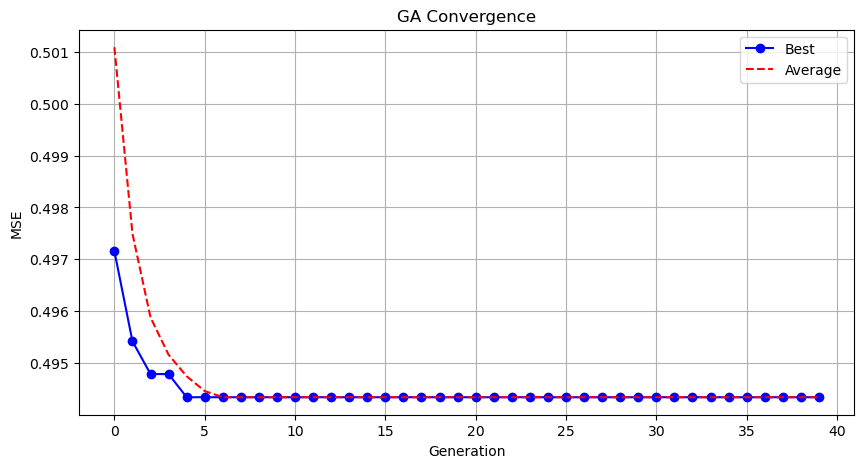

Genetic Algorithm completed successfully with MSE: 0.4943

Running Particle Swarm Optimization...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 60 particles
- Iterations: 40
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.502251
New best for swarm at iteration 1: [1.         0.10047949 0.80345972 0.50782911 0.83267326 0.66023438
 0.50459836 0.48464727 0.00855099 0.67342872 0.65113751 1.
 0.80725706 1.        ] 0.497700035572052
Best after iteration 1: [1.         0.10047949 0.80345972 0.50782911 0.83267326 0.66023438
 0.50459836 0.48464727 0.00855099 0.67342872 0.65113751 1.
 0.80725706 1.        ] 0.497700035572052
New best for swarm at iteration 2: [0.8030648  0.97745777 0.72655569 0.52651901 1.         0.46405102
 1.         0.50685367 0.43301782 0.05798867 1.         0.87006673
 0.98024505 1.        ] 0.4

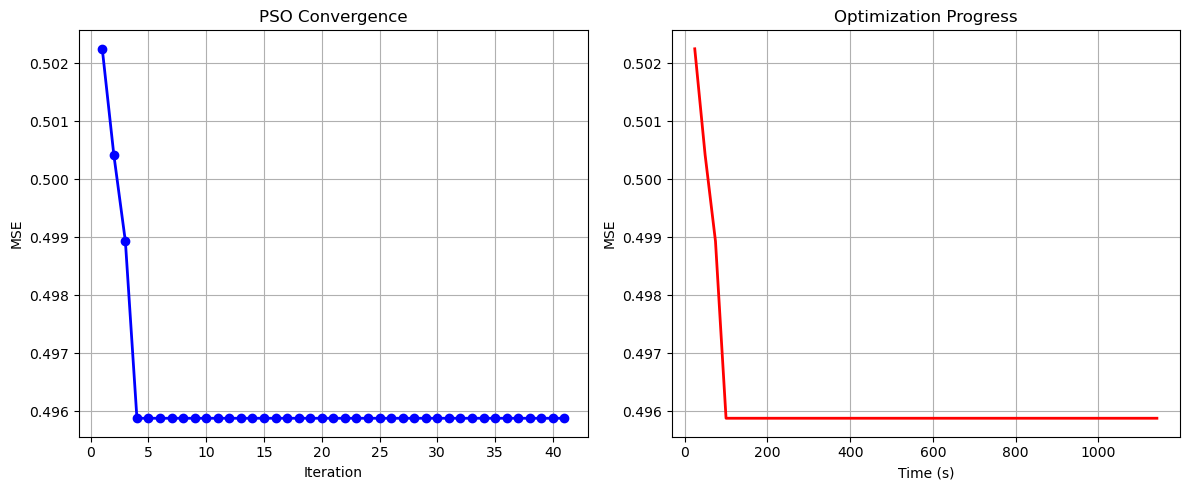

Particle Swarm Optimization completed successfully with MSE: 0.4943

Running Whale Optimization...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 60 whales
- Max iterations: 40
- Spiral coefficient (b): 1.0
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 40/40 | Best MSE: 0.494339

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494339
▶ Time elapsed: 1085.60 seconds
▶ Features selected: 14/14 (0.0% reduction)

▶ Selected features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. 10
12. 11
13. 12
14. 13

▶ Convergence progress:
- Initial MSE: 0.5066
- Final MSE: 0.4943
- Improvement: 2.4%


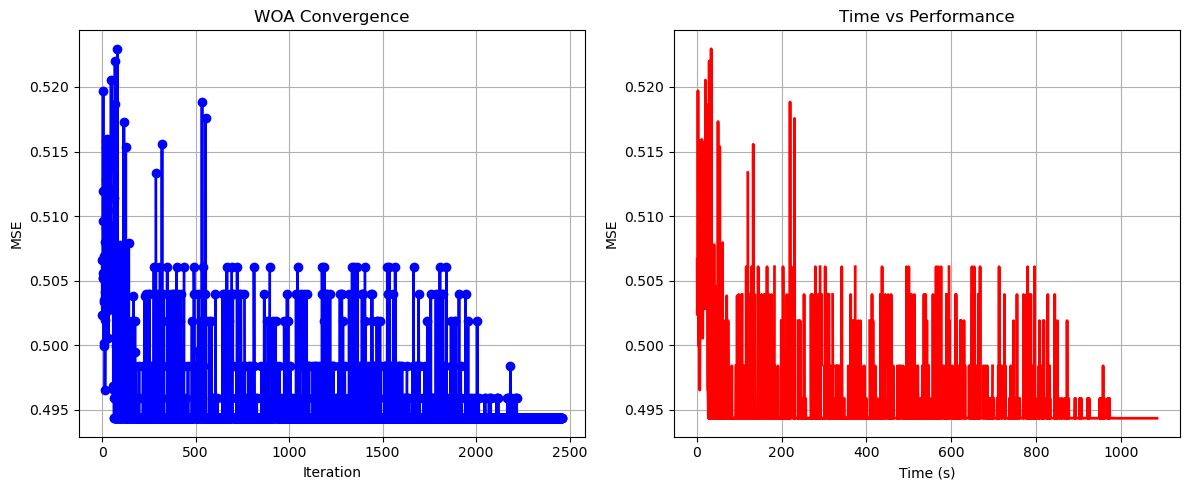

Whale Optimization completed successfully with MSE: 0.4943

Running Squid Game Optimizer...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 60 (30 offensive, 30 defensive)
- Max games: 40
- Search space: 14 features
- Target: Minimize MSE using XGBoost


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494339
▶ Time elapsed: 1063.02 seconds
▶ Features selected: 14/14 (0.0% reduction)

▶ Selected features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. 10
12. 11
13. 12
14. 13

▶ Convergence progress:
- Initial MSE: 0.4973
- Final MSE: 0.4943
- Improvement: 0.6%


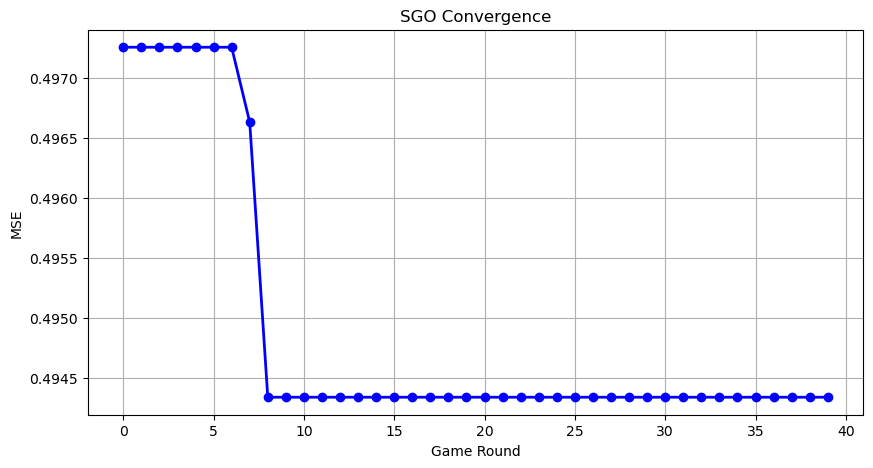

Squid Game Optimizer completed successfully with MSE: 0.4943

Running PSH-Hyptrite...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 60
- Max iterations: 40
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 40/40 | Best MSE: 0.494339 | Radius: 0.0125

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494339
▶ Time elapsed: 3319.41 seconds
▶ Features selected: 14/14 (0.0% reduction)

▶ Selected features (with weights):
1. 0 (weight: 0.761)
2. 1 (weight: 0.868)
3. 2 (weight: 0.700)
4. 3 (weight: 0.671)
5. 4 (weight: 1.000)
6. 5 (weight: 0.523)
7. 6 (weight: 0.763)
8. 7 (weight: 0.705)
9. 8 (weight: 0.562)
10. 9 (weight: 0.797)
11. 10 (weight: 0.819)
12. 11 (weight: 0.726)
13. 12 (weight: 0.616)
14. 13 (weight: 0.533)


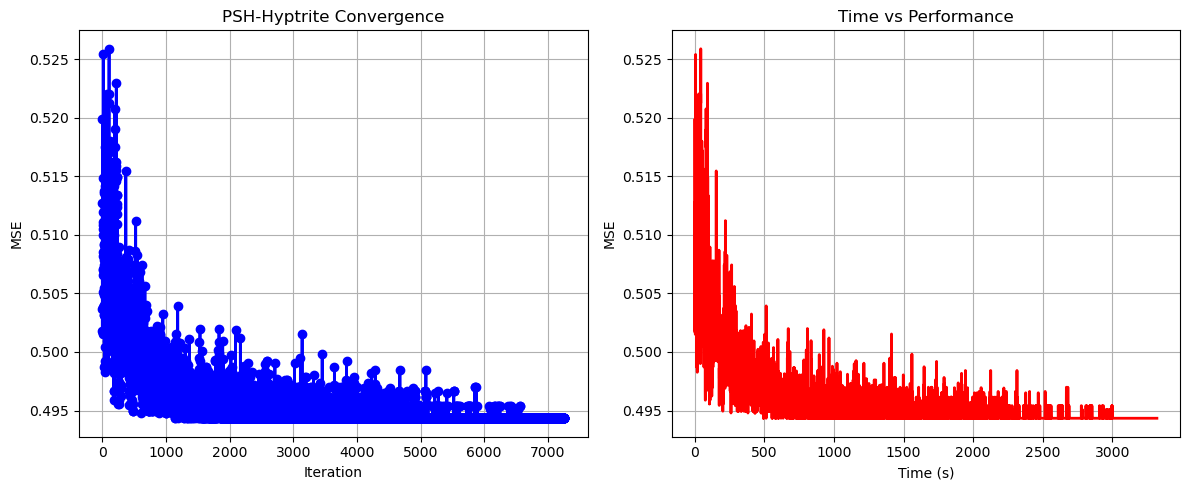

PSH-Hyptrite completed successfully with MSE: 0.4943


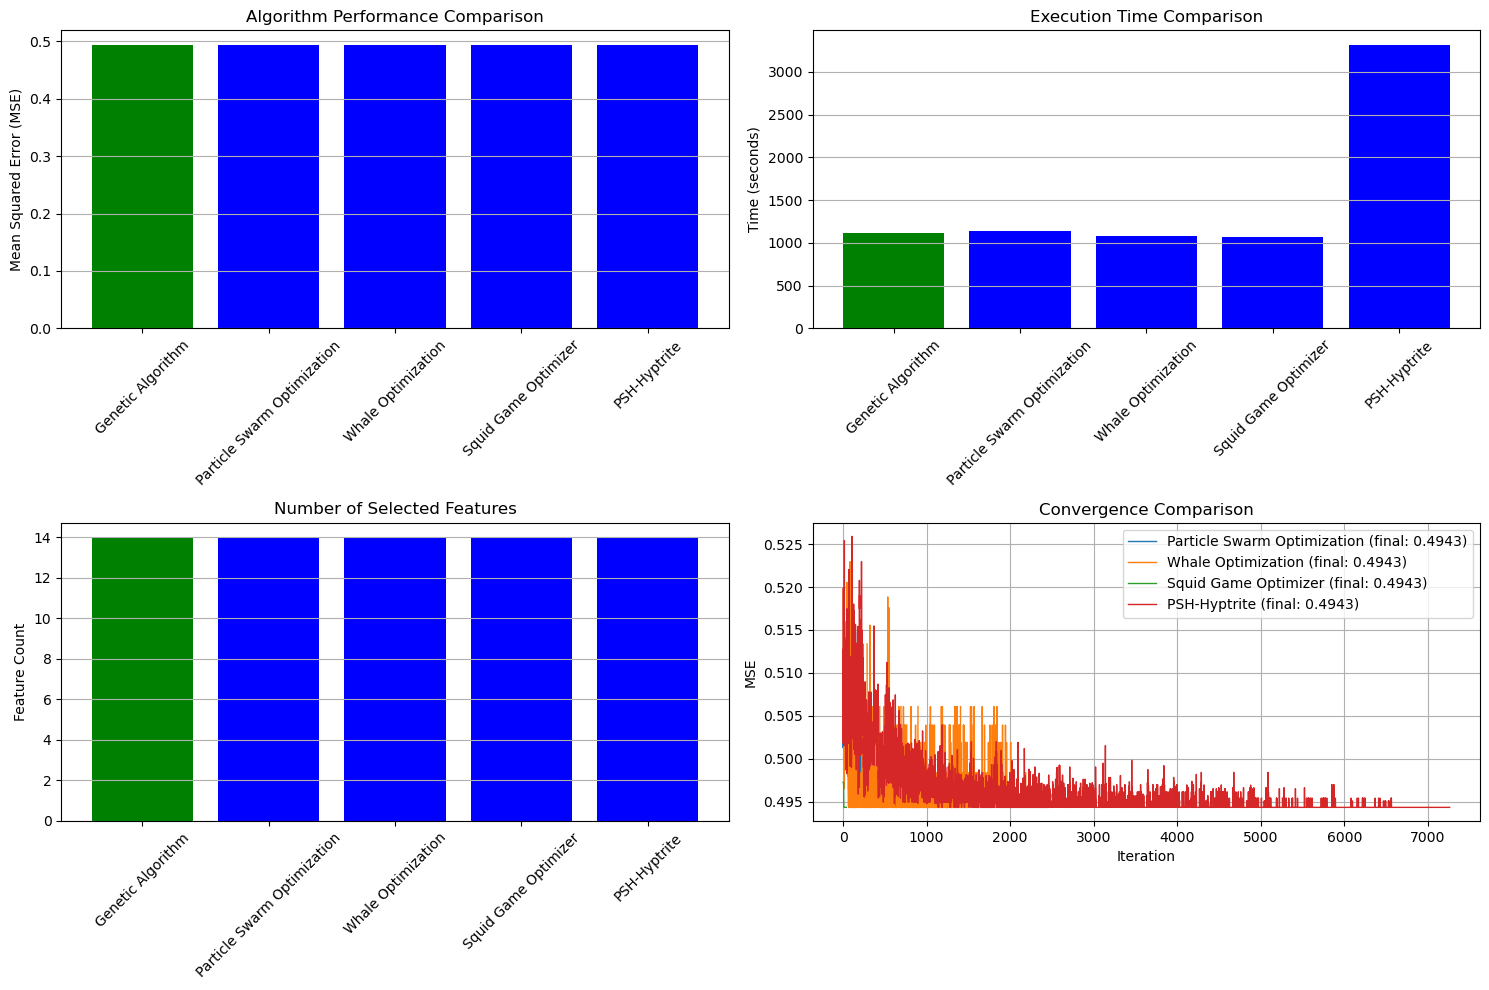


FINAL RESULTS SUMMARY

🏆 Best Algorithm: Genetic Algorithm
📉 Best MSE Achieved: 0.494339
⏱️ Execution Time: 1110.28 seconds
🔢 Features Selected: 14

Selected Features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. 10
12. 11
13. 12
14. 13


In [92]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)